Importing dependencies and loading the dataset

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Path of the file to read.
data_path = "countries-aggregated_csv.csv"
# Reading the file
data = pd.read_csv(data_path )

## Simple Multi-Linear Regression modeling

Making target y and input X for the XGBRegressor model and then splitting X and y into validation and training data.

In [16]:
# Target
y = data['Deaths']

# Features
features = ['Confirmed', 'Recovered']
X = data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

# Defining the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
    ])

# Preprocessing the training data.
train_X = preprocessor.fit_transform(train_X)
val_X = preprocessor.transform(val_X)


Search space for hyperparameters.

In [13]:
# Define the search space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 18, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "random_state": 1,
    "seed": 0,
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "booster": "gbtree",
}

Method that trains the model with the given parameters and calculates the MAE score and returns loss, status of the model.


In [14]:
def get_params(space):
    # Inputing the parameters
    model = xgb.XGBRegressor(**space)
    
    # Evaluation set
    eval_set = [(train_X, train_y), (val_X, val_y)]

    # Fit the model on the eval_set with early stopping
    model.fit(train_X, train_y, eval_set=eval_set, eval_metric="mae", early_stopping_rounds=50, verbose=False)

    # Get model predictions
    y_pred = model.predict(val_X)

    # Calculate MAE
    mae = mean_absolute_error(val_y, y_pred)
    print(f"MAE: {mae}")

    return {'loss': mae, 'status': STATUS_OK, 'model': model}

Bayesian optimization algorithm to find the most optimized parameters for the model.

In [15]:
trials = Trials()

best_params = fmin(fn=get_params,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials)

MAE: 146.09109136083902                               
MAE: 84.73853860129421                                                          
MAE: 77.43838327399514                                                          
MAE: 97.39075355475067                                                         
MAE: 488.92350552822666                                                        
MAE: 80.25820110007845                                                         
MAE: 97.96113248184805                                                         
MAE: 160.2403378058738                                                         
MAE: 472.0181773691171                                                         
MAE: 66.33735187525747                                                         
MAE: 112.57565502454374                                                         
MAE: 80.95158551074188                                                          
MAE: 94.63967556708155                                       

Inputing the algorithm results to define the XGBRegressor model.

In [16]:
xgb_best_model = trials.best_trial['result']['model']
print("The best hyperparameters are:")
print(best_params)
print("\nThe best optimized model:")
print(xgb_best_model)

The best hyperparameters are:
{'gamma': 4.1529192487015, 'learning_rate': 0.23356933588702536, 'max_bin': 345.0, 'max_depth': 14.0, 'min_child_weight': 0.0, 'n_estimators': 945.0, 'reg_alpha': 0.7955416040282769, 'reg_lambda': 0.21721771149866065}

The best optimized model:
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.1529192487015, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.23356933588702536, max_bin=345,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=945, n_jobs=None, num_parallel_tree=None

Testing how much better the optimized model is compared to the standard model.

In [17]:
# Testing the best model with the validation data
xgb_best_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
xgb_best_model_pred = xgb_best_model.predict(val_X)
xgb_best_model_mae = mean_absolute_error(val_y, xgb_best_model_pred)
print(f"MAE_Best_Model: {xgb_best_model_mae}")

# Testing the standard model with the validation data
xgb_standart_model = xgb.XGBRegressor()
xgb_standart_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
xgb_standart_model_pred = xgb_standart_model.predict(val_X)
xgb_standart_model_mae = mean_absolute_error(val_y, xgb_standart_model_pred)
print(f"MAE_Standard_Model: {xgb_standart_model_mae}")
print(f"MAE_Difference: {xgb_standart_model_mae - xgb_best_model_mae}")

MAE_Best_Model: 65.02643490380201
MAE_Standard_Model: 488.9359605975645
MAE_Difference: 423.9095256937625


Checking if the model underfits or overfits.

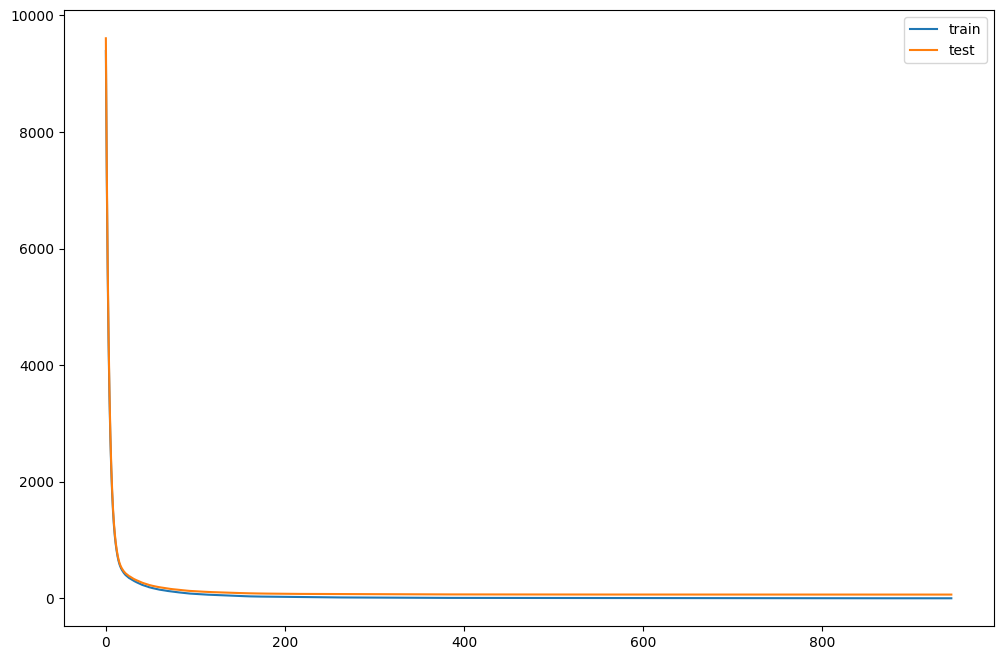

In [26]:
results = xgb_best_model.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='train')
plt.plot(results['validation_1']['mae'], label='test')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

The validation and training losses seem to decrease close to zero, so the model is learning and not underfitting on both training and test cases. The losses also do not start to increase at any point, so the model does not seem to be overfitting on both training and test cases. Both plots are almost identical, so the model seems to be predicting unknown target cases quite well. We could try using different linear regression models, but XGBoost seems to do a great job with HyperOpt optimisation, so this is not necessary.

The problem with this type of modelling is that it forces all countries to fit into a simple linear regression model, which does not give us realistic or useful information because we cannot get meaningful continuous predictions for certain countries. Instead, we should try to classify the countries with the features 'confirmed', 'recovered' and 'deaths' and perhaps add some other features to the dataset that might give us more information. On the other hand, we could try to use clustering and create new classes to which each country belongs.

## Classification

Feature engineering

In [ ]:
# Copying the data
modified_data = data.copy()

# Features
features = ['Confirmed', 'Recovered', 'Deaths']
X = modified_data[features].copy()

# Target
y = modified_data['Country'].copy()

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

# Preprocessing
train_X = preprocessor.fit_transform(train_X)
val_X = preprocessor.transform(val_X)



## Change log

| Date | Version | Change Description |
| --- | --- | --- |
| 29.5.2024 | 1.0.1 | Removed variance plot. Added more descriptions. Fixed preprocessing and removed country from the feature list |